In [1]:
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
from scipy import stats
from calendar import month_name
import matplotlib.patches as patches
pplt.rc['reso']='xx-hi'
warnings.filterwarnings('ignore')

Specify the directory where the raw precipitation data is, and set the directory where the figures will be saved. Define the latitude/longitude bounds for the full domain and our subregions of interest. Specify "monthly pairs" for precipitation analysis (i.e., ```MONTHPAIRS = [(6,7),(7,8)]``` instructs the analysis to examine changes from June to July and July to August).

In [2]:
FILEDIR    = '/global/cfs/cdirs/m4334/sferrett/monsoon-pod/data/interim'
SAVEDIR    = '/global/cfs/cdirs/m4334/sferrett/monsoon-pod/figs'
REGIONS    = {
    'Eastern Arabian Sea':{'latmin':9.,'latmax':19.5,'lonmin':64.,'lonmax':72.}, 
    'Central India':{'latmin':18.,'latmax':24.,'lonmin':76.,'lonmax':83.},
    'Central Bay of Bengal':{'latmin':9.,'latmax':14.5,'lonmin':86.5,'lonmax':90.},
    'Equatorial Indian Ocean':{'latmin':5.,'latmax':10.,'lonmin':62.,'lonmax':67.5},
    'Konkan Coast':{'latmin':15.,'latmax':19.5,'lonmin':69.,'lonmax':72.5}} 
LATRANGE   = (5.,25.)
LONRANGE   = (60.,90.)
MONTHPAIRS = [(6,7),(7,8)]
CONFIDENCE = 0.95

In [3]:
def load(filename,filedir=FILEDIR,varlist=None):
    filepath = f'{filedir}/{filename}'
    ds = xr.open_dataset(filepath)
    if varlist:
        ds = ds[varlist]
    return ds.load()

In [4]:
hrimerg = load('HR_ERA5_IMERG_baseline.nc',varlist=['pr'])
lrimerg = load('LR_ERA5_IMERG_baseline.nc',varlist=['pr'])
lrgpcp  = load('LR_ERA5_GPCP_baseline.nc',varlist=['pr'])

Calculate the monthly precipitation climatology for each month in our precipitation datasets, then calculate the differences between between specified pairs of months from ```MONTHPAIRS```.

In [5]:
def calc_monthly_diffs(data,monthpairs=MONTHPAIRS):
    monthlypr = data.groupby('time.month').mean(dim='time')
    diffs = []
    for startmonth,endmonth in monthpairs:
        diff = monthlypr.sel(month=endmonth)-monthlypr.sel(month=startmonth)
        diffs.append(diff)
    return monthlypr,diffs

Obtain significance masks for the monthly precipitation differences via ```get_sig_masks()```. This function calculates where the month-to-month change in precipitation is statistically significant relative to interannual variability. It uses a two-tailed paired *t*-test to create masks where ```True``` values indicate staistically significant changes, based on a confidence level specified by ```confidencelevel``` (default is 95%).

In [6]:
def get_sig_masks(data,monthpairs=MONTHPAIRS,confidence=CONFIDENCE):
    sigmasks = []
    for startmonth,endmonth in monthpairs:
        start = data.sel(time=data['time.month']==startmonth).groupby('time.year').mean(dim='time')
        end   = data.sel(time=data['time.month']==endmonth).groupby('time.year').mean(dim='time')
        tstat,pval = stats.ttest_rel(end.values,start.values,axis=0)
        sigmask = pval<(1-confidence)
        sigmask = xr.DataArray(sigmask,coords={'lat':start.lat,'lon':start.lon},dims=['lat','lon'])
        sigmasks.append(sigmask)
    return sigmasks

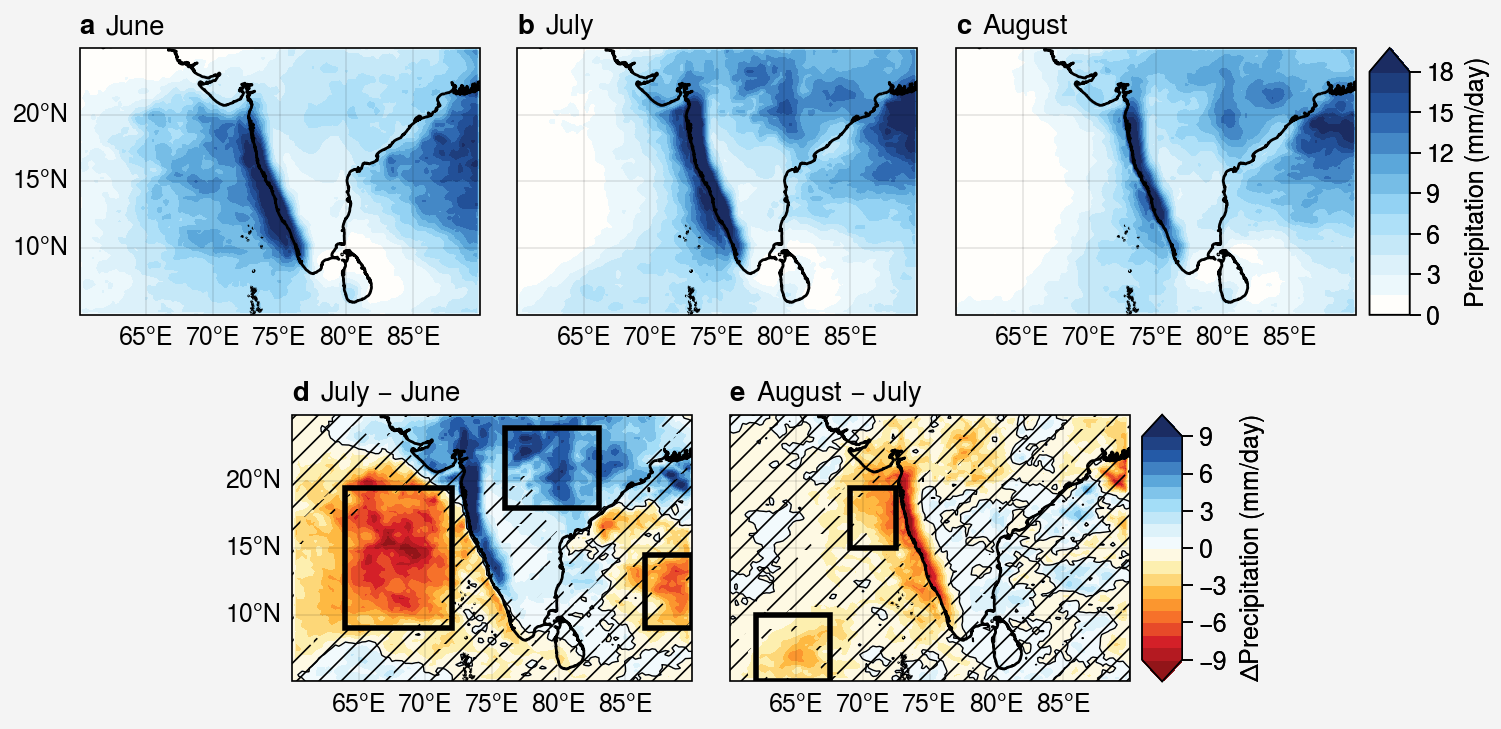

In [7]:
def create_plot(data,latrange=LATRANGE,lonrange=LONRANGE,regions=REGIONS,monthpairs=MONTHPAIRS,confidence=CONFIDENCE,filename=None):
    fig,axs = pplt.subplots([[1,1,2,2,3,3],[0,4,4,5,5,0]],abc=True,proj='cyl',refwidth=2)
    axs.format(coast=True,coastlinewidth=1,latlim=latrange,latlines=[10,15,20],lonlim=lonrange,lonlines=5,lonlabels=True)
    monthlypr,diffs = calc_monthly_diffs(data,monthpairs)
    sigmasks = get_sig_masks(data,monthpairs,confidence)
    for i,month in enumerate(monthlypr.month.values):
        ax = axs[i]
        ax.format(titleloc='l',title=f'{month_name[month]}',latlabels=(i==0))
        m = ax.contourf(monthlypr.sel(month=month),cmap='ColdHot_r',cmap_kw={'left':0.5},vmin=0,vmax=18,levels=15,extend='max')
    for i,(diff,sigmask,(startmonth,endmonth)) in enumerate(zip(diffs,sigmasks,monthpairs)):
        ax = axs[i+3]
        ax.format(titleloc='l',title=f'{month_name[endmonth]} $-$ {month_name[startmonth]}',latlabels=(i==0))
        n = ax.contourf(diff,cmap='ColdHot_r',vmin=-9,vmax=9,levels=22,extend='both')
        ax.contour(diff,color='k',levels=[0],linewidth=0.5)
        ax.contourf(~sigmask,colors='none',levels=[0,0.5,1],hatches=['','///'])    
    for i,coords in enumerate(list(regions.values())):
        j = 3 if i<3 else 4
        axs[j].add_patch(patches.Rectangle(
            (coords['lonmin'],coords['latmin']),coords['lonmax']-coords['lonmin'],coords['latmax']-coords['latmin'],
            edgecolor='k',facecolor='none',linewidth=2))
    fig.colorbar(m,loc='r',ax=axs[2],label='Precipitation (mm/day)',ticks=3,space=-0.5)
    fig.colorbar(n,loc='r',ax=axs[4],label='$\Delta$Precipitation (mm/day)',ticks=3) 
    pplt.show()
    if filename:
        fig.save(f'{SAVEDIR}/{filename}',dpi=900)

create_plot(hrimerg.pr,filename='fig_1.png')

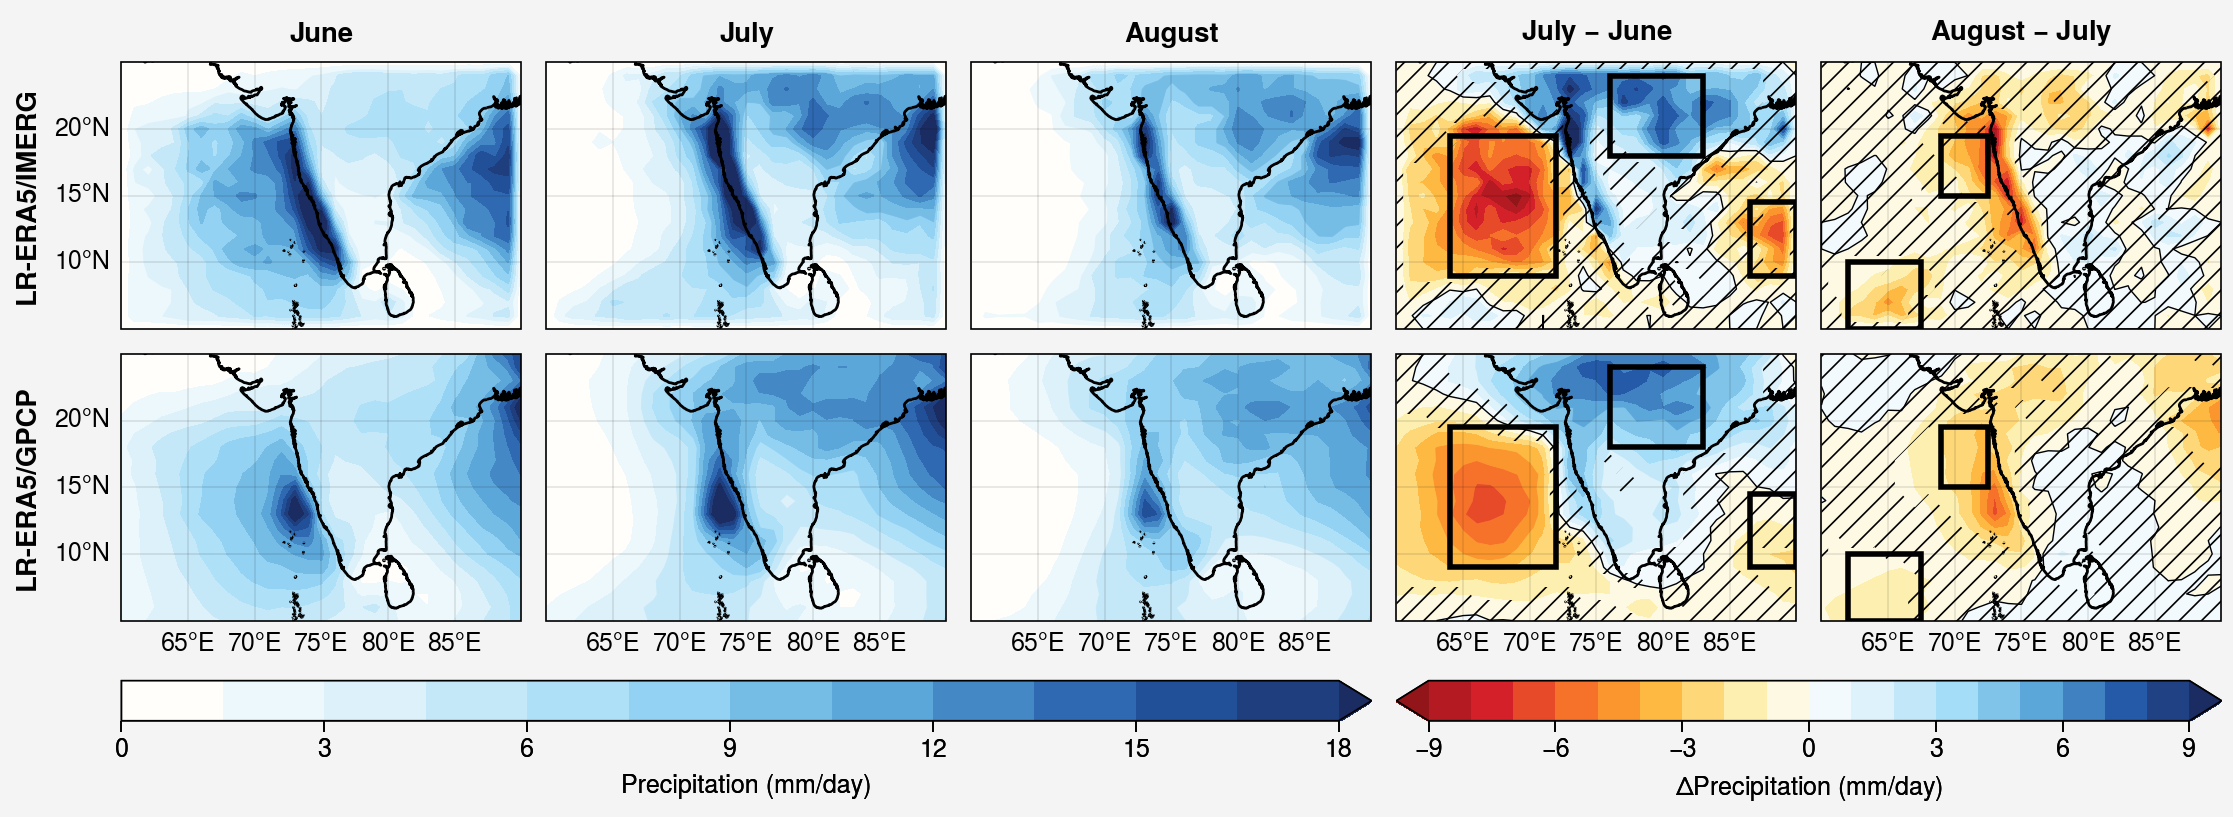

In [8]:
def create_si_plot(datadict,latrange=LATRANGE,lonrange=LONRANGE,regions=REGIONS,monthpairs=MONTHPAIRS,confidence=CONFIDENCE,filename=None):
    datalist = [item[0] for item in datadict]
    namelist = [item[1] for item in datadict]
    fig,axs = pplt.subplots(nrows=len(datalist),ncols=len(regions),proj='cyl',refwidth=2)
    axs.format(rowlabels=namelist,collabels=['June','July','August','July $-$ June','August $-$ July'],
               coast=True,coastlinewidth=1,latlim=latrange,latlines=[10,15,20],
               lonlim=lonrange,lonlines=5)
    axs[:,0].format(latlabels=True)
    axs[1,:].format(lonlabels=True)
    for i,data in enumerate(datalist):
        monthlypr,diffs = calc_monthly_diffs(data,monthpairs)
        sigmasks        = get_sig_masks(data,monthpairs,confidence)
        for j,month in enumerate(monthlypr.month.values):
            ax = axs[i,j]
            a = ax.contourf(monthlypr.sel(month=month),cmap='ColdHot_r',cmap_kw={'left':0.5},vmin=0,vmax=18,levels=15,extend='max')
        for j,(diff,sigmask,(startmonth,endmonth)) in enumerate(zip(diffs,sigmasks,monthpairs)):
            ax = axs[i,j+3]
            b = ax.contourf(diff,cmap='ColdHot_r',vmin=-9,vmax=9,levels=22,extend='both')
            ax.contour(diff,color='k',levels=[0],linewidth=0.5)
            ax.contourf(~sigmask,colors='none',levels=[0,0.5,1],hatches=['','///'])
        for j,coords in enumerate(list(regions.values())):
            k = 3 if j<3 else 4
            axs[i,k].add_patch(patches.Rectangle(
                (coords['lonmin'],coords['latmin']),coords['lonmax']-coords['lonmin'],coords['latmax']-coords['latmin'],
                edgecolor='k',facecolor='none',linewidth=2))
    fig.colorbar(a,loc='b',cols=(1,3),label='Precipitation (mm/day)',ticks=3)
    fig.colorbar(b,loc='b',cols=(4,5),label='$\Delta$Precipitation (mm/day)',ticks=3)
    pplt.show()
    if filename:
        fig.save(f'{SAVEDIR}/{filename}',dpi=900)

datadict = [
    (lrimerg.pr,'LR-ERA5/IMERG'),
    (lrgpcp.pr,'LR-ERA5/GPCP')]
create_si_plot(datadict,filename='fig_S1.png')